In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

In [6]:
def over_sampler(df,column_name):
    ''' Params: df,column_name="string" 
    The function will oversample based on the class you want to match. Save as df and then use train_test_split to cut down 
    the data.
      '''
    
    df=df.copy()
    # gathering the classes/counts and respective percentages to convert to dictionary for easy accesiblilty later
    classes = df[column_name].value_counts(normalize=False).index.tolist()
    counts = df[column_name].value_counts(normalize=False).tolist()
    percentages = (round(df[column_name].value_counts(normalize=True)*100,3)).tolist()
    diction=dict(zip(classes,counts))
    
    # getting input data so we can quckly iterate
    input_user = int(input('What class do we want from needs to be an INT(our case ~ 0-9)?'))
    count_goal = diction.get(input_user)
    # creating list of dataframes of randomly oversample observations 
    #            Note: not usable for time series w/o adjustment as to what df passed in 
    df_list = []
    for k,v in diction.items():
        # ensuring oversampling classes w/counts below the designated input class
        if v < count_goal:
            n_samples=count_goal-v
            rows_to_append = df[df[column_name]==k].sample(n =n_samples,replace=True,random_state=42) # oversampling here
            df_list.append(rows_to_append)

    # merging list of dfs into on whole df 
    samples_df = pd.concat(df_list)
    # merging dataframe of oversamples obs to original passed in df to return
    over_sample_class =pd.concat([df,samples_df])
    
    return over_sample_class

        

In [7]:
over_class = over_sampler(df,'class')
print(over_class.shape[0])
over_class['class'].value_counts()

What class do we want from needs to be an INT(our case ~ 0-9)? 3


219739


0    55304
1    38521
2    22983
5    18769
4    17182
3    13396
8    13396
6    13396
7    13396
9    13396
Name: class, dtype: int64

In [2]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv('../../data.csv')

In [23]:
df2= pd.read_csv('../../Data/complete_fire.csv')

In [24]:
df2.head()

,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,year,...,area (acres),population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in)
0,2003-WYCMX-200237,-105.563067,44.603340,139.091837,Unknown,SCHWARTZ,1.0,Campbell,WY,2003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-CABDU-006784,-117.076679,34.733894,1906.698008,Unknown,MENTONE,1.0,San Bernardino,CA,2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-IDGBK-000002,-116.216680,43.666673,685.728842,Unknown,NIFC RAMP SUPPORT,1.0,Ada,ID,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-IDCTF-008902,-111.426912,42.096336,20.000000,Unknown,St. Charles RX,0.0,Bear Lake,ID,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-AZPNF-000975,-112.072414,34.598306,77.946287,Unknown,Mingus/Cherry Rx,0.0,Yavapai,AZ,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df2 = df2.dropna()

In [28]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
numdf = df2.copy().select_dtypes(include=numerics)
catdf = df2.copy().select_dtypes(include=categorical)
catdf.drop(columns=['unique_fire_identifier','incident_name'],inplace=True)
catdf.head()

,fire_cause,origin_county,state
34889,Human,Ada,ID
34890,Undetermined,Beltrami,MN
34891,Undetermined,Beltrami,MN
34892,Undetermined,Yavapai,AZ
34893,Human,San Juan,NM


In [29]:
# will dummify these features to obtain correlations  
dummified_1 = pd.get_dummies(data=catdf,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1.head()

(167273, 1400)


,lattitude,longitude,acres_burned,IsFSAssisted,year,month,value,anomaly,area (acres),population,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
34889,-116.330913,43.406206,0.1,1.0,2016,4,47.0,6.0,53487360.0,1684036.0,...,0,0,0,0,0,0,0,0,0,0
34890,-94.916910,48.017407,0.1,0.0,2016,4,42.5,1.2,55643520.0,5525360.0,...,0,0,0,0,0,0,0,0,0,0
34891,-95.015306,47.875908,0.1,0.0,2016,4,42.5,1.2,55643520.0,5525360.0,...,0,0,0,0,0,0,0,0,0,0
34892,-112.761608,34.201307,0.5,0.0,2016,4,58.5,1.8,72963840.0,6944767.0,...,0,0,0,0,0,0,0,0,0,0
34893,-108.537233,36.744172,0.5,1.0,2016,4,52.3,0.9,77819520.0,2092555.0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
dict2 = { 'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9}

In [5]:
df['class'] = df['class'].replace(dict2)

In [31]:
dummified_1['class'] = dummified_1['class'].replace(dict2)

KeyError: 'class'

In [61]:
df.head()

,Unnamed: 0,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,...,population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in),class
0,34889,2016-IDBOD-000058,-116.330913,43.406206,0.1,Human,SOUTH CLOVER,1.0,Ada,ID,...,1684036.0,8.043333,0.000000,0.000000,0.0,0.0,8.043333,24.13,0.040772,0
1,34890,2016-MNRLA-000184,-94.916910,48.017407,0.1,Undetermined,RL 130,0.0,Beltrami,MN,...,5525360.0,9.663333,1.026667,0.000000,0.0,0.0,11.716667,35.15,0.040886,0
2,34891,2016-MNRLA-000185,-95.015306,47.875908,0.1,Undetermined,RL 131,0.0,Beltrami,MN,...,5525360.0,9.663333,1.026667,0.000000,0.0,0.0,11.716667,35.15,0.040886,0
3,34892,2016-AZA5S-002056,-112.761608,34.201307,0.5,Undetermined,KRISTEE,0.0,Yavapai,AZ,...,6944767.0,32.776667,65.580000,1.170000,0.0,0.0,167.446667,502.34,0.031042,1
4,34893,2016-AZNAA-000033,-108.537233,36.744172,0.5,Human,HOGBACK 1,1.0,San Juan,NM,...,2092555.0,53.023333,43.686667,0.086667,0.0,0.0,140.656667,421.97,0.235141,1


In [8]:
df['class'].value_counts()

0    55304
1    38521
2    22983
5    18769
4    17182
3    13396
7      499
6      445
8       91
9       83
Name: class, dtype: int64

In [7]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [40]:
oversample = RandomOverSampler()

In [41]:
X_b, y_b = oversample.fit_resample(X, y)

In [42]:
y_b.value_counts()

A    55304
B    55304
D    55304
C    55304
F    55304
E    55304
I    55304
G    55304
H    55304
J    55304
Name: class, dtype: int64

In [14]:
X_2, y_2 = undersample.fit_resample(X, y)

In [15]:
y_2.value_counts()

B    38521
C    22983
F    18769
E    17182
D    13396
H      499
G      445
I       91
A       83
J       83
Name: class, dtype: int64

In [16]:
undersample2 = RandomUnderSampler(sampling_strategy='majority')

In [17]:
X_3, y_3 = undersample.fit_resample(X_2, y_2)

In [18]:
y_3.value_counts()

C    22983
F    18769
E    17182
D    13396
H      499
G      445
I       91
A       83
B       83
J       83
Name: class, dtype: int64

In [19]:
undersample4 = RandomUnderSampler(sampling_strategy='majority')

In [20]:
X_4, y_4 = undersample.fit_resample(X_3, y_3)

In [21]:
undersample5 = RandomUnderSampler(sampling_strategy='majority')

In [22]:
X_5, y_5 = undersample.fit_resample(X_4, y_4)

In [23]:
undersample6 = RandomUnderSampler(sampling_strategy='majority')

In [24]:
X_6, y_6 = undersample.fit_resample(X_5, y_5)

In [25]:
undersample7 = RandomUnderSampler(sampling_strategy='majority')

In [26]:
X_7, y_7 = undersample.fit_resample(X_6, y_6)

In [27]:
undersample8 = RandomUnderSampler(sampling_strategy='majority')

In [28]:
X_8, y_8 = undersample.fit_resample(X_7, y_7)

In [29]:
undersample9 = RandomUnderSampler(sampling_strategy='majority')

In [30]:
X_9, y_9 = undersample.fit_resample(X_8, y_8)

In [31]:
y_9.value_counts()

I    91
A    83
B    83
C    83
D    83
E    83
F    83
G    83
H    83
J    83
Name: class, dtype: int64

In [32]:
undersample10 = RandomUnderSampler(sampling_strategy='majority')

In [33]:
X_10, y_10 = undersample.fit_resample(X_9, y_9)

In [8]:
X = over_class[['precipitation(in)', 'value', 'anomaly', 'area (acres)', 'population', 'd0', 'd1', 'd2', 'd3', 'd4', 'DSCI_avg', 'DSCI_summed']]
y = over_class['class']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [16]:
rf.score(X_train, y_train) 

0.5048519282015185

In [12]:
rf.score(X_test, y_test)

0.4917805569881382

In [17]:
f1_score(y_test, y_pred2, average = 'micro')

0.41192318194229544

In [19]:
f1_score(y_test, y_pred2, average = 'macro')

0.2976940934028779

In [21]:
f1_score(y_test, y_pred2, average = 'weighted')

0.3517708557170146

In [15]:
y_pred = rf.predict(X_test)

In [15]:
cm = confusion_matrix(y_test, y_pred2)

In [16]:
cm_df = pd.DataFrame(cm,
                     index = ['A','B','C', 'D','E','F','G','H','I','J'], 
                     columns = ['A','B','C', 'D','E','F','G','H','I','J'])

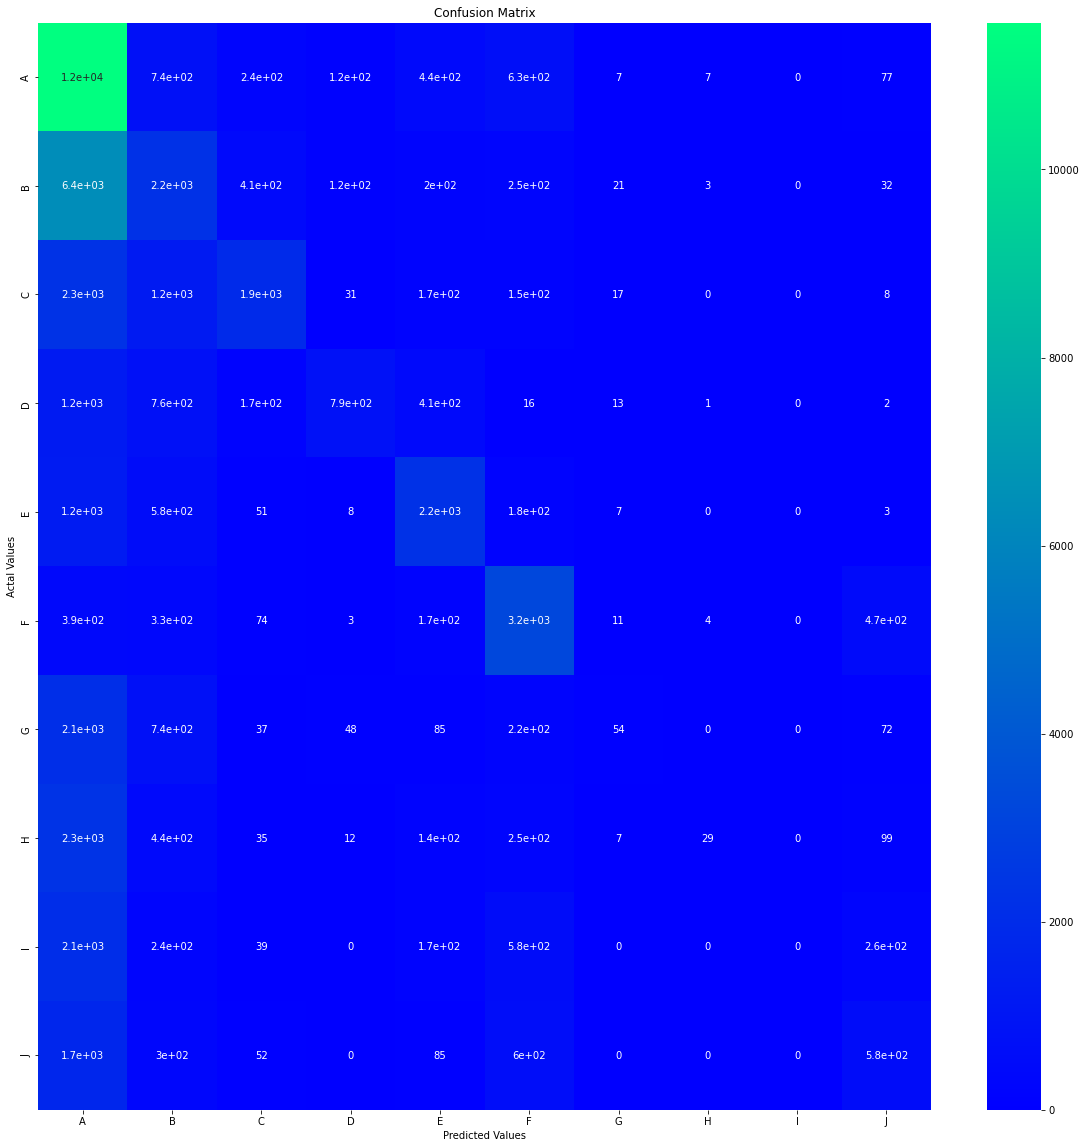

In [22]:
#Plotting the confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(cm_df, annot=True, cmap = 'winter')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [15]:
# Average is assigned micro
#
precisionScore_sklearn_microavg = precision_score(y_test, y_pred, average='micro')
#
# Average is assigned macro
#
precisionScore_sklearn_macroavg = precision_score(y_test, y_pred, average='macro')
#
# Printing micro and macro average precision score
#
precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg

NameError: name 'precision_score' is not defined

In [ ]:
pipe = Pipeline([
    ('model', RandomForestClassifier())
])

In [ ]:
pipe_params = {
    'model__n_estimators': [10,50,100, 200],
    'model__max_depth': [None, 1, 2, 3]
    
}

In [ ]:
gs = GridSearchCV(pipe, pipe_params, cv =5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
print(gs.best_params_)

In [ ]:
gs.score(X_test, y_test)

In [11]:
gb = GradientBoostingClassifier(n_estimators = 10)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=10)

In [12]:
gb.score(X_train, y_train) 

0.41383704279022354

In [13]:
gb.score(X_test, y_test)

0.41192318194229544

In [14]:
y_pred2 = gb.predict(X_test)

In [ ]:
ab = AdaBoostClassifier(n_estimators = 10)
ab.fit(X_train, y_train)

In [ ]:
ab.score(X_train, y_train) 

In [ ]:
ab.score(X_test, y_test)

In [ ]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

In [ ]:
kn.score(X_train, y_train) 

In [ ]:
kn.score(X_test, y_test)